In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exercise 4- Using LSTMs, see if you can write Shakespeare!
In this course you’ve done a lot of NLP and text processing. This week you trained with a dataset of Irish songs to create traditional-sounding poetry. For this week’s exercise, you’ll take a corpus of Shakespeare sonnets, and use them to train a model. Then, see if that model can create poetry!

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words) # One hot encoding

--2020-05-22 08:31:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-05-22 08:31:24 (107 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



**Note:** Don't forget to set return_sequences = True for an LSTM layer feeding another one!

In [13]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 10, 300)           301200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              163761    
Total params: 931,511
Trainable params: 931,511
Non-trainable params: 0
________________________________________________

In [14]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 13s 26ms/step - loss: 7.0242 - accuracy: 0.0206
Epoch 2/100
484/484 [==============================] - 12s 26ms/step - loss: 6.5356 - accuracy: 0.0228
Epoch 3/100
484/484 [==============================] - 13s 26ms/step - loss: 6.4539 - accuracy: 0.0216
Epoch 4/100
484/484 [==============================] - 12s 26ms/step - loss: 6.4070 - accuracy: 0.0248
Epoch 5/100
484/484 [==============================] - 13s 26ms/step - loss: 6.3619 - accuracy: 0.0278
Epoch 6/100
484/484 [==============================] - 12s 26ms/step - loss: 6.3148 - accuracy: 0.0314
Epoch 7/100
484/484 [==============================] - 12s 26ms/step - loss: 6.2637 - accuracy: 0.0299
Epoch 8/100
484/484 [==============================] - 13s 26ms/step - loss: 6.2125 - accuracy: 0.0310
Epoch 9/100
484/484 [==============================] - 13s 26ms/step - loss: 6.1678 - accuracy: 0.0341
Epoch 10/100
484/484 [==============================] - 13s 26ms/step - l

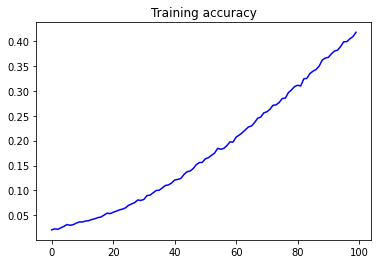

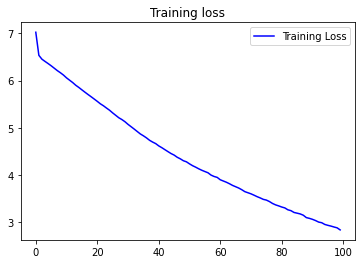

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [16]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope in thee as look at a treasure doth deeds ' his end now shake his wrongs new deserts west with thee assured away me assured his doom and date eyes to gone must no woe muse being good dear deeds doth prove thee ' dost flower than no sake quite delight ' free find must make must steel ' strangely so my love go pleasure skill be small worth love ' must good dear ' might never die from woe wilt approve no view light ' ' must each look ' be fortune newer do not grow fair good end
